In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats
pd.options.mode.chained_assignment = None

In [15]:
df = pd.read_csv("Food_Scrap_Generators.csv")
df.drop(columns=['Phone','Website','Facebook','Active'], inplace=True)
df.drop([5905,6034], inplace=True)
df.dropna(subset=['X','Y'], inplace=True)
df.reset_index(drop=True, inplace=True)

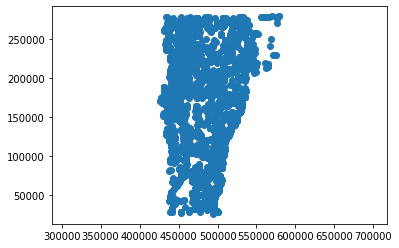

In [16]:
fig, axs = plt.subplots()
axs.scatter(df.X,df.Y)
axs.axis('equal')
plt.show()

In [17]:
conversion_df = df[["X","Y"]]
conversion_df.to_csv("food_sources_locs_EPSG32145.csv", header=False, index=False)
converted_df = pd.read_csv("food_sources_locs_latlon.csv")
lat_lon = converted_df.filter(items=['Latitude','Longitude'])
df_lat_lon = lat_lon.join(df)
df_lat_lon.drop(labels=['X','Y'], axis=1, inplace=True)
df_lat_lon.head()

,Latitude,Longitude,ID,FSGName,TonsPerWeek,TYPE1,TYPE2,TYPE3,Address,Town,County,Zip
0,43.454391,-72.409799,1,BROOKHAVEN CATERER,0.050,Food Establishment,Caterer,NaN,1470 ROUTE 44,WINDSOR,WINDSOR,05089
1,43.492291,-72.394699,2,VERMONT WHOLE FOODS CATERING,0.050,Food Establishment,Caterer,NaN,153 PEMBROKE RD,WINDSOR,WINDSOR,05089
2,43.492291,-72.394699,3,JUNIPER HILL INN,0.735,Food Establishment,Restaurant,NaN,153 PEMBROKE ROAD,WINDSOR,WINDSOR,05089
3,43.476891,-72.388099,4,WINDSOR ELKS BPO LODGE 1665,1.680,Food Establishment,Restaurant,NaN,156 MAIN ST,WINDSOR,WINDSOR,05089
4,43.501991,-72.392599,5,JOHN P LARKIN COUNTRY CLUB,0.945,Food Establishment,Restaurant,NaN,1571 ROUTE 5 NORTH,WINDSOR,WINDSOR,05089


In [18]:
df_lat_lon.dropna(subset=['TYPE2'], inplace=True)
our_sources_df = df_lat_lon[df_lat_lon['TYPE2'].isin(['Restaurant','Convenience Store','Grocery'])]
our_sources_df.TYPE2.value_counts()

Restaurant           2379
Grocery               458
Convenience Store     269
Name: TYPE2, dtype: int64

In [19]:
fig = px.scatter_mapbox(our_sources_df, lat="Latitude", lon="Longitude", color="TYPE2", hover_name="FSGName", hover_data=["Address"], zoom=6.3)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
fig.write_html("food_sources.html")

In [8]:
our_sources_df['County'] = our_sources_df['County'].str.upper()
our_sources_df.loc[5120, "County"] = "ORANGE"

In [9]:
# area in km^2, population
county_data = {
    "ADDISON":[1994,37363],
    "BENNINGTON":[1751,37347],
    "CALEDONIA":[1686,30233],
    "CHITTENDEN":[1396,168323],
    "ESSEX":[1722,5920],
    "FRANKLIN":[1650,49946],
    "GRAND ISLE":[215,7293],
    "LAMOILLE":[1194,25945],
    "ORANGE":[1785,29277],
    "ORLEANS":[1805,27393],
    "RUTLAND":[2414,60572],
    "WASHINGTON":[1787,59807],
    "WINDHAM":[2044,45905],
    "WINDSOR":[2515,57753]
}
county_df = pd.DataFrame.from_dict(county_data, orient="index", columns=["Area","Population"])
county_df['Pop. Density'] = county_df['Population']/county_df['Area']


In [10]:
restaurant_counts = pd.DataFrame(our_sources_df.loc[our_sources_df.TYPE2=="Restaurant"].County.value_counts())
grocery_counts = pd.DataFrame(our_sources_df.loc[our_sources_df.TYPE2=="Grocery"].County.value_counts())
convenience_counts = pd.DataFrame(our_sources_df.loc[our_sources_df.TYPE2=="Convenience Store"].County.value_counts())
county_to_count = {"County":"Count"}
restaurant_counts.rename(columns=county_to_count, inplace=True)
grocery_counts.rename(columns=county_to_count, inplace=True)
convenience_counts.rename(columns=county_to_count, inplace=True)
restaurant_df = restaurant_counts.join(county_df)
grocery_df = grocery_counts.join(county_df)
convenience_df = convenience_counts.join(county_df)

In [13]:
restaurant_df['Source Density'] = restaurant_df['Count']/restaurant_df['Area']
grocery_df['Source Density'] = grocery_df['Count']/grocery_df['Area']
convenience_df['Source Density'] = convenience_df['Count']/convenience_df['Area']

,Count,Area,Population,Pop. Density,Source Density
RUTLAND,54,2414,60572,25.091964,0.022370
WASHINGTON,37,1787,59807,33.467823,0.020705
BENNINGTON,25,1751,37347,21.328955,0.014278
WINDSOR,25,2515,57753,22.963419,0.009940
CHITTENDEN,23,1396,168323,120.575215,0.016476
WINDHAM,19,2044,45905,22.458415,0.009295
ORANGE,16,1785,29277,16.401681,0.008964
FRANKLIN,15,1650,49946,30.270303,0.009091
LAMOILLE,11,1194,25945,21.729481,0.009213
CALEDONIA,9,1686,30233,17.931791,0.005338


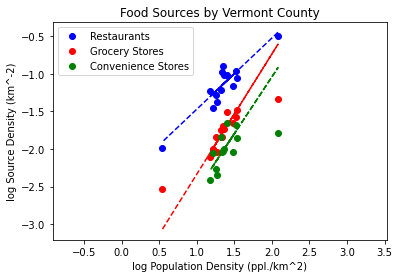

Restaurant alpha:  0.947836618418219
Grocery alpha:  1.6004757940978092
Convenience alpha:  1.5129148388367026


In [45]:
fig, ax = plt.subplots()
ax.axis('equal')
restaurant_mod = scipy.stats.linregress(np.log10(restaurant_df[~restaurant_df.index.isin(['CHITTENDEN','ESSEX'])]['Pop. Density']), np.log10(restaurant_df[~restaurant_df.index.isin(['CHITTENDEN','ESSEX'])]['Source Density']))
grocery_mod = scipy.stats.linregress(np.log10(grocery_df[~grocery_df.index.isin(['CHITTENDEN','ESSEX'])]['Pop. Density']), np.log10(grocery_df[~grocery_df.index.isin(['CHITTENDEN','ESSEX'])]['Source Density']))
convenience_mod = scipy.stats.linregress(np.log10(convenience_df[~convenience_df.index.isin(['CHITTENDEN','ESSEX'])]['Pop. Density']), np.log10(convenience_df[~convenience_df.index.isin(['CHITTENDEN','ESSEX'])]['Source Density']))
ax.plot('Pop. Density','Source Density','bo',data=np.log10(restaurant_df), label="Restaurants")
ax.plot(np.log10(restaurant_df['Pop. Density']), restaurant_mod.intercept + restaurant_mod.slope*np.log10(restaurant_df['Pop. Density']), 'b--')
ax.plot('Pop. Density','Source Density','ro', data=np.log10(grocery_df), label="Grocery Stores")
ax.plot(np.log10(grocery_df['Pop. Density']), grocery_mod.intercept + grocery_mod.slope*np.log10(grocery_df['Pop. Density']), 'r--')
ax.plot('Pop. Density','Source Density', 'go',data=np.log10(convenience_df), label="Convenience Stores")
ax.plot(np.log10(convenience_df['Pop. Density']), convenience_mod.intercept + convenience_mod.slope*np.log10(convenience_df['Pop. Density']), 'g--')
ax.set_xlabel("log Population Density (ppl./km^2)")
ax.set_ylabel("log Source Density (km^-2)")
ax.set_title("Food Sources by Vermont County")
ax.legend()
plt.show()
print("Restaurant alpha: ", restaurant_mod.slope)
print("Grocery alpha: ", grocery_mod.slope)
print("Convenience alpha: ", convenience_mod.slope)